# Linear Models

The following just gives us some tools we'll need

In [25]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from numpy.random import multivariate_normal
from sklearn.metrics import accuracy_score

In [26]:
# A small utility we shall need later:
def maxpos(A):
    '''
    Takes an n x k array A, and returns 1-dim n array where the i'th
    entry is the index of column in A where the i'th row of A has its
    maximal value (application: turns a probabilitiy distribution over
    k classes for n instances into a single prediction)
    '''
    return np.argmax(A,axis=1)


## Iris Data and Decision Regions

We load the Iris dataset and inspect what it is about. Iris is probably the most heavily used dataset in machine learning. It even has its own Wikipedia page: https://en.wikipedia.org/wiki/Iris_flower_data_set

In [27]:
irisdata = load_iris()

print(irisdata.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

The Iris data contains 4 features. In order to facillitate visualization of decision regions,
it is better to use two features only, that then can be plotted in 2D. Here we select
two features, and make a scatter plot of their values:

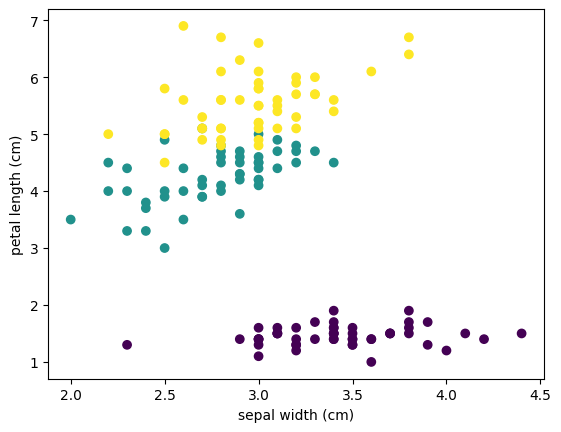

In [28]:
feat1 = 1
feat2 = 2
plt.scatter(irisdata.data[:,feat1],irisdata.data[:,feat2],c=irisdata.target)
plt.xlabel(irisdata['feature_names'][feat1])
plt.ylabel(irisdata['feature_names'][feat2])
plt.show()

We next define and train several classification models. We continue to only use the first two features of the data.

First, the **K nearest neighbor** model. To define the model, we have to select the value of K, here called n_neighbors. The .fit function is the generic function for model training. For the K nearest neighbor model there is no actual training, however. 

In [29]:
irisknn = KNeighborsClassifier(n_neighbors=3)
irisknn.fit(irisdata.data[:,[feat1,feat2]],irisdata.target)


KNeighborsClassifier(n_neighbors=3)

Plotting labeled data points and decision regions. First, a meshgrid is constructed consisting of a fine grid of points that we classify, and then use for visualization of the decision regions. Then, our classifier is applied to the grid.


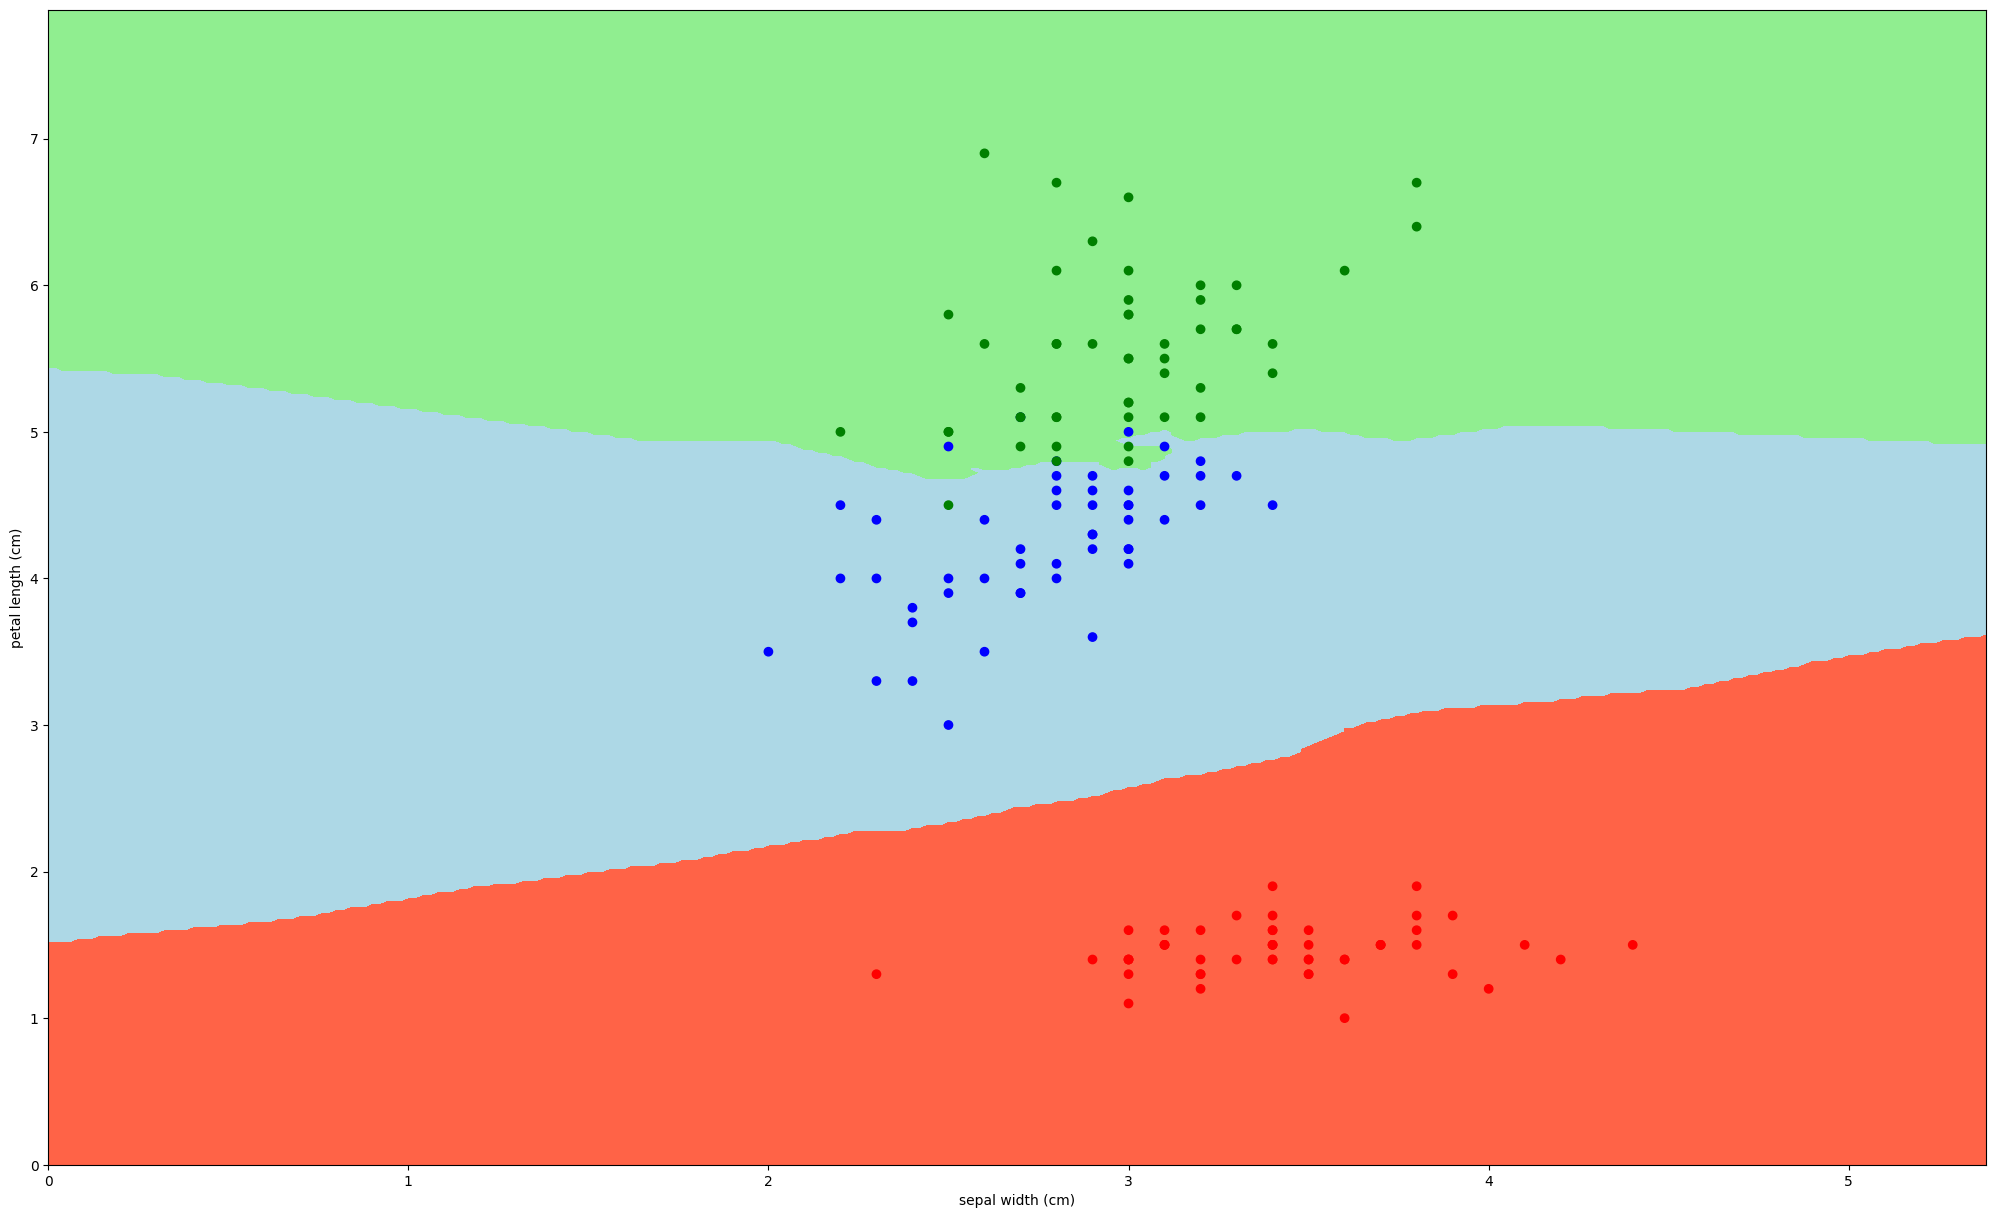

In [30]:
maxval1 = np.max(irisdata.data[:,feat1])
maxval2 = np.max(irisdata.data[:,feat2])

xx, yy = np.meshgrid(np.arange(0, maxval1+1, 0.02), np.arange(0, maxval2+1, 0.02))

meshclasses = irisknn.predict(np.c_[xx.ravel(), yy.ravel()])
meshclasses = meshclasses.reshape(xx.shape)

plt.figure(figsize=(25,15))
plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
plt.scatter(irisdata.data[:,feat1],irisdata.data[:,feat2],c=irisdata.target, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
plt.xlabel(irisdata['feature_names'][feat1])
plt.ylabel(irisdata['feature_names'][feat2])

plt.show()

## Linear Functions

We define a simple linear classifier for 2-dimensional inputs with manually defined parameters w,w0 for the linear function:

In [31]:
w=[0.3,4.5]
w0=1.5

def predict(w,w0,x):
    return np.sign(np.dot(w,x)+w0)

We can again visualize the decision regions defined by the function:

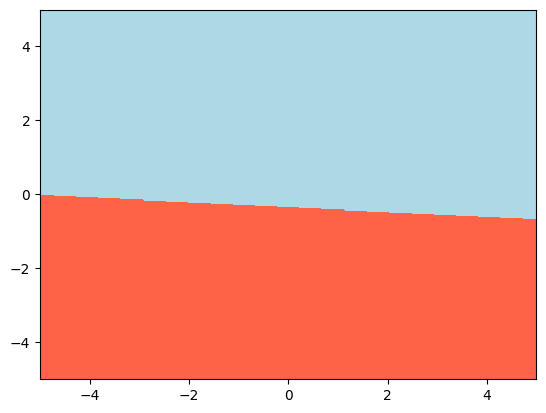

In [32]:
xx, yy = np.meshgrid(np.arange(-5, 5, 0.03), np.arange(-5, 5, 0.03))

meshclasses=np.vectorize(predict,signature='(n),(),(n)->()')(w,w0,np.c_[xx.ravel(), yy.ravel()])
meshclasses = meshclasses.reshape(xx.shape)
plt.contourf(xx,yy,meshclasses,[-1.5,0,1.5],colors=('tomato','lightblue'))
plt.show()

Now we construct a small linearly separable dataset:

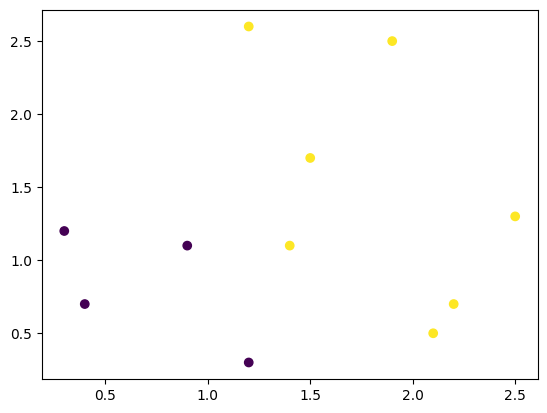

In [33]:
features=np.array([[0.3,1.2],[0.4,0.7],[1.2,2.6],[2.1,0.5],[1.2,0.3],[0.9,1.1],[2.5,1.3],[2.2,0.7],[1.9,2.5],[1.5,1.7],[1.4,1.1]])
labels=np.array([-1,-1,1,1,-1,-1,1,1,1,1,1])
plt.scatter(features[:,0],features[:,1],c=labels)
plt.show()

**Exercise 1**:  Determine parameters w,w0 so that predict(w,w0,:) has zero error on this dataset. Plot the decision regions of your predictor together with the datapoints. Use as few trial and error settings for w,w0 as possible (ideally: zero trial and error). 

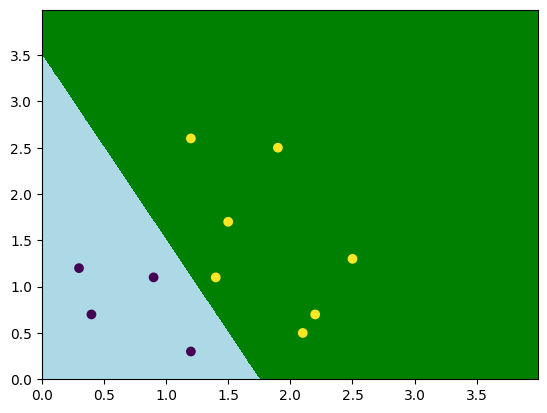

In [34]:
w0_new, w_new = 3.5, [-2,-1]

xx, yy = np.meshgrid(np.arange(0, 4, 0.01), np.arange(0, 4, 0.01))
meshclasses=np.vectorize(predict,signature='(n),(),(n)->()')(w_new,w0_new,np.c_[xx.ravel(), yy.ravel()])
meshclasses = meshclasses.reshape(xx.shape)

plt.contourf(xx,yy,meshclasses,[-1.5,0,1.5],colors=('green','lightblue'))
plt.scatter(features[:,0],features[:,1],c=labels)
plt.show()

## Least Squares Regression

The least squares classification model corresponds to LinearRegression in sklearn with one-hot-encoding class labels as targets. We here fit a linear regression model to the Iris data, and visualize the decision regions:

In [35]:
onehotclasses = np.zeros((irisdata.target.size, len(irisdata.target_names)))
for i in range(irisdata.target.size):
    onehotclasses[i][irisdata.target[i]]=1.0

irislinreg = LinearRegression()
irislinreg.fit(irisdata.data[:,[feat1,feat2]],onehotclasses)

LinearRegression()

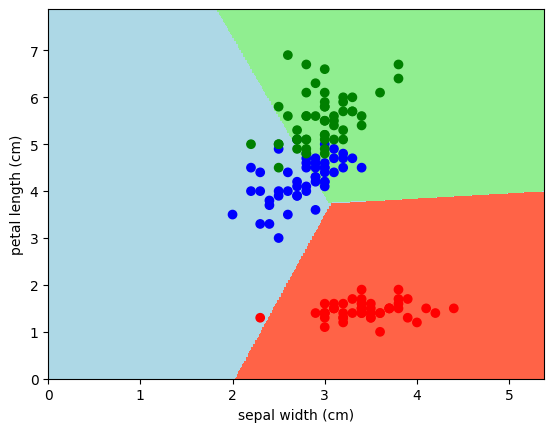

In [36]:
maxval1 = np.max(irisdata.data[:,feat1])
maxval2 = np.max(irisdata.data[:,feat2])
xx, yy = np.meshgrid(np.arange(0, maxval1+1, 0.02), np.arange(0, maxval2+1, 0.02))

Z = irislinreg.predict(np.c_[xx.ravel(), yy.ravel()])
meshclasses = maxpos(Z)
meshclasses = meshclasses.reshape(xx.shape)

plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
plt.scatter(irisdata.data[:,feat1],irisdata.data[:,feat2],c=irisdata.target, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
plt.xlabel(irisdata['feature_names'][feat1])
plt.ylabel(irisdata['feature_names'][feat2])
plt.show()

**Exercise 2** Manually construct two datasets with three classes, where: 
<ul>
    <li>for the first dataset the LinearRegression classifier finds a 100% accurate model</li>
    <li>for the second dataset the LinearRegression classifier does not learn a 100% accurate model, but you can manually define the coefficients in the model so that you get 100% accuracy</li>
    </ul>
    
You can create a LinearRegression model with your manually constructed parameters by setting the .coef_ and .intercept_ attributes:    

<pre>mymodel= LinearRegression()
mymodel.coef_ = (your matrix of coefficients)
mymodel.intercept_ = (your vector of w0 parameters)
</pre>

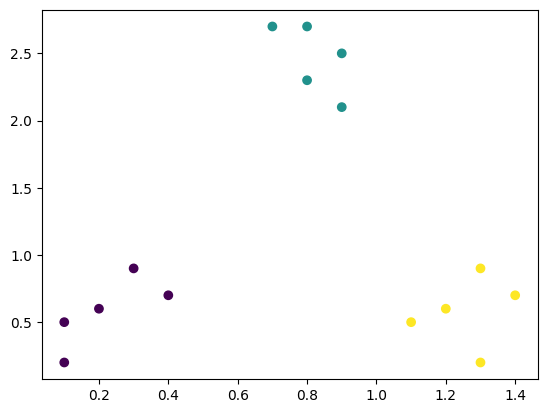

In [37]:
features=np.array([[0.1,0.2],[0.4,0.7],[0.2,0.6],[0.1,0.5],[0.3,0.9],[0.9,2.1],[0.8,2.3],[0.8,2.7],[0.9,2.5],[0.7,2.7],[1.3,0.2],[1.4,0.7],[1.2,0.6],[1.1,0.5],[1.3,0.9]])
labels=np.array([-1,-1,-1,-1,-1,0,0,0,0,0,1,1,1,1,1])
plt.scatter(features[:,0],features[:,1],c=labels)
plt.show()

In [38]:
onehotclasses = np.zeros((labels.size,3))
for i in range(labels.size):
    onehotclasses[i][labels[i]]=1.0

m1 = LinearRegression()
m1.fit(features,onehotclasses)
m1.coef_,m1.intercept_

(array([[-0.00657653,  0.4980754 ],
        [ 0.91645873, -0.29062458],
        [-0.9098822 , -0.20745082]]),
 array([-0.26263564, -0.01859804,  1.28123368]))

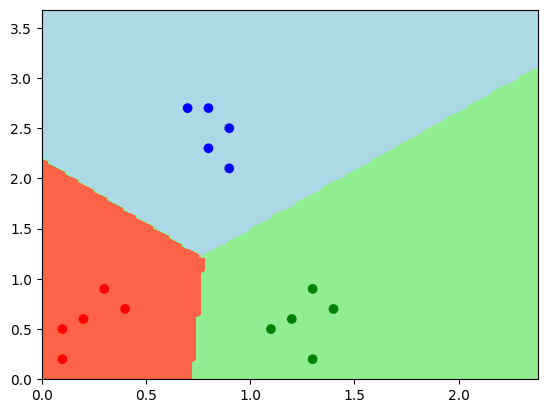

In [39]:
maxval1 = np.max(features[:,0])
maxval2 = np.max(features[:,1])
xx, yy = np.meshgrid(np.arange(0, maxval1+1, 0.02), np.arange(0, maxval2+1, 0.02))
w0 = m1.intercept_
w = m1.coef_

Z = m1.predict(np.c_[xx.ravel(), yy.ravel()])
meshclasses = maxpos(Z)
meshclasses = meshclasses.reshape(xx.shape)
plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('lightblue','lightgreen','tomato'))
plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
plt.show()

In [40]:
features=np.array([[0.1,0.2],[0.4,0.7],[0.2,0.6],[0.1,0.5],[0.3,0.9],[0.9,2.1],[0.8,2.3],[0.8,2.7],[0.9,2.5],[0.7,2.7],[1.3,0.2],[1.4,0.7],[1.2,0.6],[0.55,0.5],[1.3,0.9]])
labels=np.array([-1,-1,-1,-1,-1,0,0,0,0,0,1,1,1,1,1])

onehotclasses = np.zeros((labels.size,3))
for i in range(labels.size):
    onehotclasses[i][labels[i]]=1.0

m1 = LinearRegression()
m1.fit(features,onehotclasses)
m1.coef_,m1.intercept_

(array([[-0.01062807,  0.49858803],
        [ 0.86151315, -0.31471952],
        [-0.85088508, -0.1838685 ]]),
 array([-0.26053773,  0.08419029,  1.17634744]))

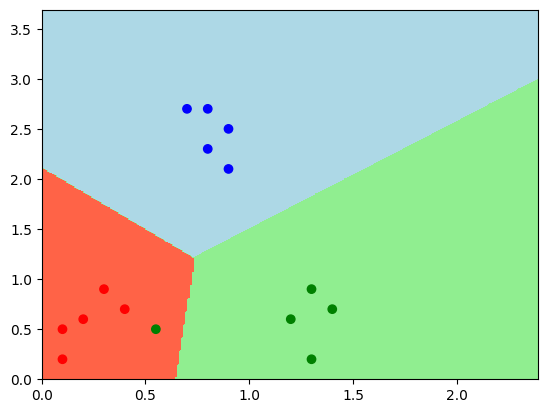

In [41]:
maxval1 = np.max(features[:,0])
maxval2 = np.max(features[:,1])
xx, yy = np.meshgrid(np.arange(0, maxval1+1, 0.01), np.arange(0, maxval2+1, 0.01))
w0 = m1.intercept_
w = m1.coef_

Z = m1.predict(np.c_[xx.ravel(), yy.ravel()])
meshclasses = maxpos(Z)
meshclasses = meshclasses.reshape(xx.shape)
plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('lightblue','lightgreen','tomato'))
plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
plt.show()

# Self Study

**Exercise 3 (self study):** Divide the Iris data into 70% training and 30% test data. Learn KNN and linear regression classifiers from the training data, and evaluate their accuracy both on the training and test data. For the KNN classifier,
draw the curves that show train/test accuracy as a function of K. Useful sklearn functions:<br>
`sklearn.model selection.train test split`<br>
`sklearn.metrics.accuracy score`<br>
`sklearn.metrics.confusion matrix`

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.

C:\Users\Vugs\AppData\Local\Temp\ipykernel_6052\2651711225.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(irisdata.data[:,feat1],irisdata.data[:,feat2],c=onehotclasses, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))


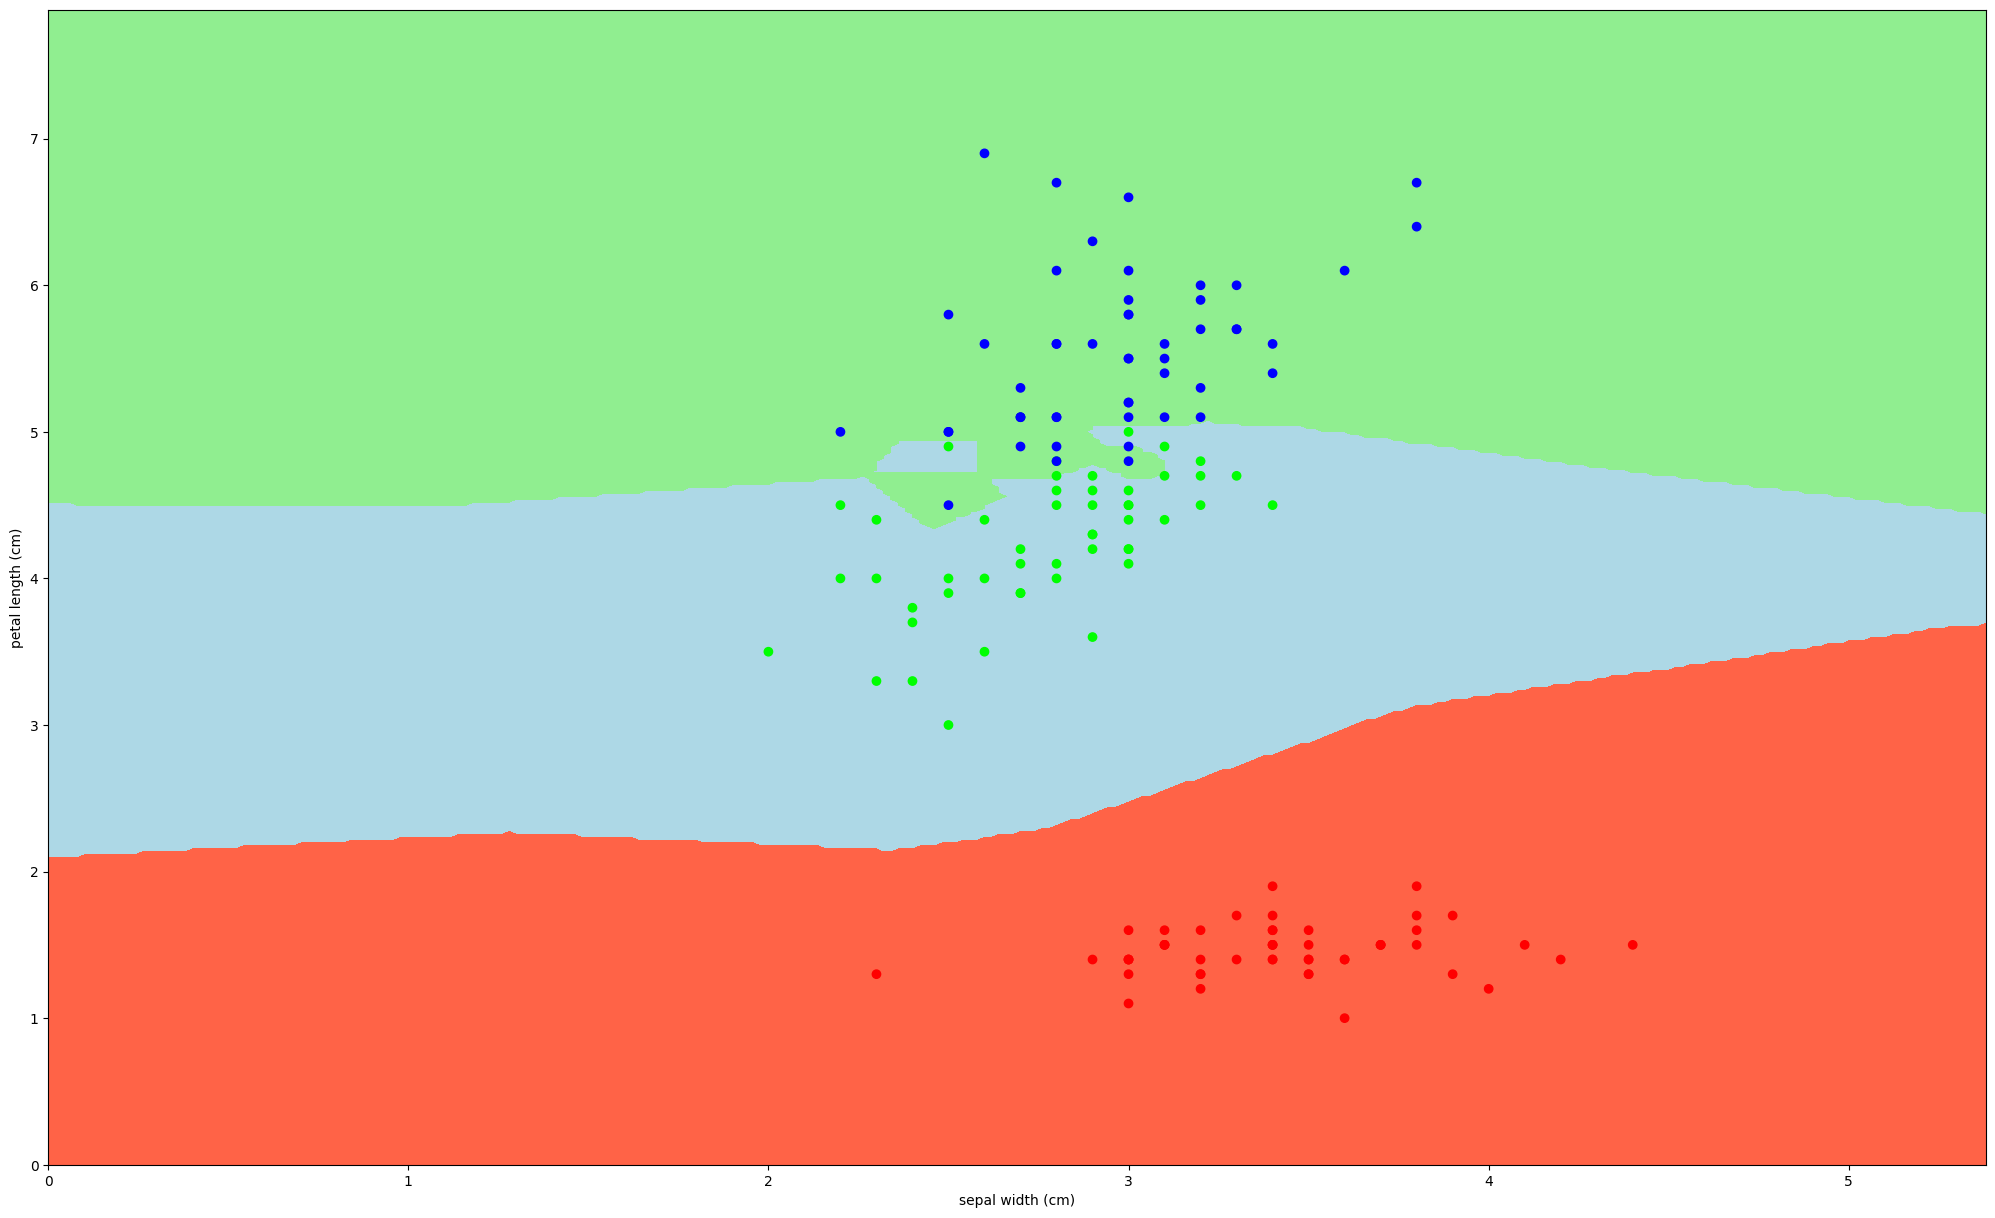

In [52]:
# Divide the iris data into 70% training and 30% test data.
from sklearn.model_selection import train_test_split

# Applying onehot encoding to the labels
onehotclasses = np.zeros((irisdata.target.size,3))
for i in range(irisdata.target.size):
    onehotclasses[i][irisdata.target[i]]=1.0

print(onehotclasses)

# X_train, X_test, y_train, y_test = train_test_split(irisdata.data[:, [feat1, feat2]], irisdata.target, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(irisdata.data[:, [feat1, feat2]], onehotclasses, test_size=0.3, random_state=42)


# Learn KNN and linear regression classifiers from the training data.
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(X_train,y_train)
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)

# Evaluate their accuracy both on the training and test data.
from sklearn.metrics import accuracy_score
print("KNN train accuracy: ",accuracy_score(y_train,knn_clf.predict(X_train)))
print("KNN test accuracy: ",accuracy_score(y_test,knn_clf.predict(X_test)))
print("Linear regression train accuracy: ",accuracy_score(y_train,lr_clf.predict(X_train).round()))
print("Linear regression test accuracy: ",accuracy_score(y_test,lr_clf.predict(X_test).round()))

# Plot the decision boundaries of the two classifiers.
maxval1 = np.max(irisdata.data[:,feat1])
maxval2 = np.max(irisdata.data[:,feat2])

xx, yy = np.meshgrid(np.arange(0, maxval1+1, 0.02), np.arange(0, maxval2+1, 0.02))

Z = knn_clf.predict(np.c_[xx.ravel(), yy.ravel()])

#meshclasses = knn_clf.predict(np.c_[xx.ravel(), yy.ravel()])
meshclasses = maxpos(Z)
meshclasses = meshclasses.reshape(xx.shape)

plt.figure(figsize=(25,15))
plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
plt.scatter(irisdata.data[:,feat1],irisdata.data[:,feat2],c=onehotclasses, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
plt.xlabel(irisdata['feature_names'][feat1])
plt.ylabel(irisdata['feature_names'][feat2])

plt.show()

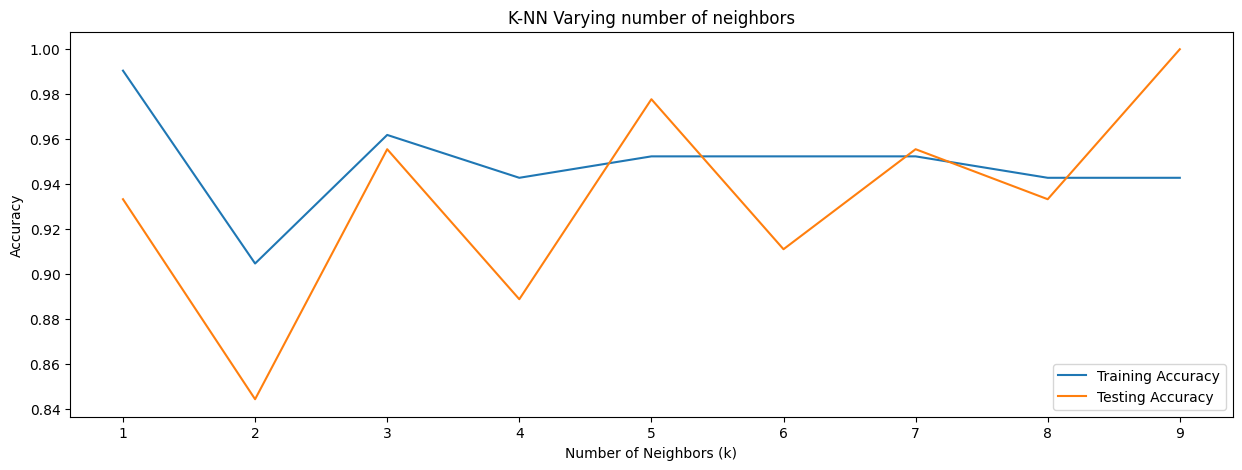

In [43]:
# For the KNN classifier,draw the curves that show train/test accuracy as a function of K.
# Learn KNN and linear regression classifiers from the training data.
train_acc = []
test_acc = []
for k in range (1,10):
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train,y_train)
    train_acc.append(accuracy_score(y_train,knn_clf.predict(X_train)))
    test_acc.append(accuracy_score(y_test,knn_clf.predict(X_test)))

# Plot the train/test accuracy curves.
k = range(1,10)
plt.figure(figsize=(15,5))
plt.plot(k, train_acc, label='Training Accuracy')
plt.plot(k, test_acc, label='Testing Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('K-NN Varying number of neighbors')
plt.legend()
plt.show()

In [44]:
# Divide the iris data into 70% training and 30% test data.
from sklearn.model_selection import train_test_split
# Applying onehot encoding to the labels
onehotclasses = np.zeros((irisdata.target.size,3))
for i in range(irisdata.target.size):
    onehotclasses[i][irisdata.target[i]]=1.0

X_train, X_test, y_train, y_test = train_test_split(irisdata.data, onehotclasses, test_size=0.3, random_state=42)



# Learn KNN and linear regression classifiers from the training data.
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(X_train,y_train)
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)

# Evaluate their accuracy both on the training and test data.
from sklearn.metrics import accuracy_score
print("KNN train accuracy: ",accuracy_score(y_train,knn_clf.predict(X_train)))
print("KNN test accuracy: ",accuracy_score(y_test,knn_clf.predict(X_test)))
print("Linear regression train accuracy: ",accuracy_score(y_train,lr_clf.predict(X_train).round()))
print("Linear regression test accuracy: ",accuracy_score(y_test,lr_clf.predict(X_test).round()))

KNN train accuracy:  1.0
KNN test accuracy:  1.0
Linear regression train accuracy:  0.7142857142857143
Linear regression test accuracy:  0.7777777777777778


**Exercise 4 (self study):**  Also perform (some) of the previous experiments using the full set of 4 predictive features. How does that
change the classification performance? Which of the 3 Iris classes is easiest to classify? Why?

The code below will fail, thus I refer to the plot above to answer the question: Which class is the easiest to predict?

In [45]:
# # Plot the decision boundaries of the two classifiers.
# maxval1 = np.max(irisdata.data[:,feat1])
# maxval2 = np.max(irisdata.data[:,feat2])
# maxval3 = np.max(irisdata.data[:,3])
# maxval4 = np.max(irisdata.data[:,0])

# xx, yy, xy, yx = np.meshgrid(np.arange(0, maxval1+1, 0.02), np.arange(0, maxval2+1, 0.02), np.arange(0, maxval3+1, 0.02), np.arange(0, maxval4+1, 0.02))

# Z = knn_clf.predict(np.c_[xx.ravel(), yy.ravel(), xy.ravel(), yx.ravel()])

# #meshclasses = knn_clf.predict(np.c_[xx.ravel(), yy.ravel()])
# meshclasses = maxpos(Z)
# meshclasses = meshclasses.reshape(xx.shape)

# plt.figure(figsize=(25,15))
# plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
# plt.scatter(irisdata.data[:,feat1],irisdata.data[:,feat2],c=onehotclasses, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
# plt.xlabel(irisdata['feature_names'][feat1])
# plt.ylabel(irisdata['feature_names'][feat2])
# plt.show()

## Gaussian mixtures

A helper function for generating data:

In [46]:
def sample_2d_gaussian(meanx,meany,variance_x,variance_y,covariance,numsamps):
    '''
    Generates a random sample of size 'numsamps' from a 2-dimensional Gaussian distribution.
    The Gaussian is defined by the mean vector (meanx,meany) and the
    covariance matrix

    variance_x    covariance
    covariance    variance_y

    All parameters can be freely chosen, except covariance, which must satisfy the inequality

    covariance <= sqrt(variance_x * variance_y)
    '''
    meanvec = np.array([meanx,meany])
    covarmatrix = np.array([[variance_x,covariance],[covariance,variance_y]])
    return multivariate_normal(meanvec,covarmatrix,numsamps)

Loading/generating data: following are two alternative ways to get data consisting of the input features stored in 'features', and the class labels, stored in 'labels'.  Only execute one of the data generating cells, before moving on to the following code!

**A**: sampling data from 2-dimensional Gaussian distributions. For reproducibility, one can fix a random seed.

In [47]:
#np.random.seed(1)
datasize=250
mixturecoeff=np.array([0.4,0.2,0.4])
componentsizes=(datasize*mixturecoeff).astype(int)

class0samp=sample_2d_gaussian(2,3,0.5,0.5,0.45,componentsizes[0])
class1samp=sample_2d_gaussian(5,3,1.0,0.5,-0.45,componentsizes[1])
class2samp=sample_2d_gaussian(3,2,0.5,0.5,0,componentsizes[2])


features=np.concatenate((class0samp,class1samp,class2samp),axis=0)
labels=np.concatenate((np.zeros(componentsizes[0]),np.ones(componentsizes[1]),2*np.ones(componentsizes[2])))

**B**: Loading mi.txt data:

In [50]:
midata = pd.read_csv("../data/MI-labeled.txt", sep=',')

In [51]:
midata

,X1,X2,Class
0,3750,-2850,M
1,3450,-2550,M
2,3750,-2475,M
3,4200,-3150,M
4,4575,-3675,M
...,...,...,...
114,8700,-3256,I
115,8925,-5325,I
116,7950,-5400,I
117,4844,-3600,M


In [ ]:
midata = pd.read_csv("./Exercises/MI-labeled.txt", sep=',')
features = np.array(midata[['X1','X2']])
classlabels=midata['Class']
labels = np.zeros(len(classlabels))
for i in range(len(classlabels)):
    if classlabels[i] == 'I':
        labels[i]=1

Preparing meshgrid for plotting decision regions:

In [ ]:
maxvalx = np.max(features[:,0])
maxvaly = np.max(features[:,1])
minvalx = np.min(features[:,0])
minvaly = np.min(features[:,1])
border=2
xinterval = (maxvalx-minvalx)/border
yinterval = (maxvaly-minvaly)/border
xx, yy = np.meshgrid(np.arange(minvalx-xinterval, maxvalx+xinterval, xinterval/100), np.arange(minvaly-yinterval, maxvaly+yinterval, yinterval/100))


Learning a classifier -- we have the choice between the Gaussian naive Bayes model, and linear discriminant analysis. 

In [ ]:
#model=GaussianNB()
model=LinearDiscriminantAnalysis()

model.fit(features,labels)

Applying model to the meshgrid. The models return probabilities for the different classes that are retrieved by the `.predict_proba` method.  We classify a datapoint as belonging to the class with the maximal probability value.

In [ ]:
Z=model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
meshclasses = maxpos(Z)
meshclasses = meshclasses.reshape(xx.shape)

Plotting datapoints and decision regions

In [ ]:
plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['b', 'b','g']))
#plt.scatter(data[:,0],data[:,1],c=classlabels_numeric, cmap = mpl.colors.ListedColormap(['r', 'b']))
plt.show()

**Exercise 5**: Investigate the decision regions of the GaussianNB and linear discriminant analysis classifiers learned from the MI-labeled.txt data. What is the explanation for their very different structure?


Two main distinctions: in Gaussian Naives Bayes, one assumes the features, X, are conditionaly indepedent on Y, and therefore we use different covariance matrices for each class. Instead, in LDA we sum over classes and use the same covariance matrix for all classes.

-- Increased covariance of blue class leads to bigger decision region in Naives Bayes. \
-- Changes in prior probability also have an affect on decision regions.

_____________

**Exercise 6 (self study)**: Create one or several linearly separable Gaussian mixture datasets (can be with only two components) for which some of the models give a perfect separation of the classes, and others don't. 

Create separate test sets using the same parameters for the Gaussian mixture as in the creation of the training set. Can you create a test/train dataset and find classifiers A and B, such that A is better than B on the training data, but B is better than A on the test set? Why is this not such an easy task for the datasets and classifiers we consider here?


## Logistic Regression

**Exercise 6**: Consider the following dataset. The data has one numeric attribute X1 , a categorical attribute X2 with three possible states {a, b, c}, and a binary class label Y:

In [ ]:
data = pd.DataFrame(  {"X1":np.array([25,2,1,-5,2,2]),"X2":pd.Categorical(['a','a','b','b','c','b']),\
                       "Y":np.array([0,1,0,0,1,0])})
display(data)

Pandas provides the get_dummies method to construct a one-hot-encoding for categorical attributes:

In [ ]:
data = pd.get_dummies(data,columns = ['X2'])
display(data)

Find parameters (manually -- without using sklearn!) for the logistic regression model that classifies these 6 datapoints correctly (there are many solutions). Once you have done that, you can check whether skl.LogisticRegression learns similar parameters. For a fitted model=LogisticRegression() you can retrieve the learned parameters via model.coef_ and model.intercept_ .

We next look at how LogisticRegression handles multiple classes

In [ ]:
irislogreg = LogisticRegression(multi_class='ovr')
irislogreg.fit(irisdata.data[:,[feat1,feat2]],irisdata.target)


In [ ]:
maxval1 = np.max(irisdata.data[:,feat1])
maxval2 = np.max(irisdata.data[:,feat2])
xx, yy = np.meshgrid(np.arange(0, maxval1+1, 0.02), np.arange(0, maxval2+1, 0.02))

Z = irislogreg.predict(np.c_[xx.ravel(), yy.ravel()])

meshclasses = Z


meshclasses = meshclasses.reshape(xx.shape)
plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
plt.scatter(irisdata.data[:,feat1],irisdata.data[:,feat2],c=irisdata.target, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
plt.xlabel(irisdata['feature_names'][feat1])
plt.ylabel(irisdata['feature_names'][feat2])
plt.show()

___

# Exercise 3 (self study) - KNN & Linear classification
Divide the Iris data into 70% training and 30% test data. Learn KNN and linear regression classifiers from the training data, and evaluate their accuracy both on the training and test data. For the KNN classifier,
draw the curves that show train/test accuracy as a function of K. Useful sklearn functions:<br>
`sklearn.model selection.train test split`<br>
`sklearn.metrics.accuracy score`<br>
`sklearn.metrics.confusion matrix`

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
feat1, feat2 = 1, 2
x_train_two_feat, x_test_two_feat, y_train_two_feat, y_test_two_feat = train_test_split(irisdata.data[:,[feat1,feat2]], irisdata.target,test_size=0.3, shuffle=True, random_state=2) # Using two features
x_train, x_test, y_train, y_test = train_test_split(irisdata.data, irisdata.target,test_size=0.3) # Using all features

### KNN

In [ ]:
# Fit a knn model to the training data and plot the train/test accuracy as a function of k
train_acc = []
test_acc = []

for k in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_two_feat,y_train_two_feat)
    train_acc.append(accuracy_score(y_train_two_feat,knn.predict(x_train_two_feat)))
    test_acc.append(accuracy_score(y_test_two_feat,knn.predict(x_test_two_feat)))

plt.plot(range(1,51),train_acc,label='train', marker='o')
plt.plot(range(1,51),test_acc,label='test', marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of k (two features)')
plt.legend()
plt.show()

In [ ]:
knn_plot_model = KNeighborsClassifier(n_neighbors=10)
knn_plot_model.fit(x_train_two_feat,y_train_two_feat)

maxval1 = np.max(x_train_two_feat[:,0])
maxval2 = np.max(x_train_two_feat[:,1])

xx, yy = np.meshgrid(np.arange(0, maxval1+1, 0.02), np.arange(0, maxval2+1, 0.02))

meshclasses = knn.predict(np.c_[xx.ravel(), yy.ravel()])
meshclasses = meshclasses.reshape(xx.shape)

plt.figure(figsize=(10,6))
plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
plt.scatter(x_test_two_feat[:,0],x_test_two_feat[:,1],c=y_test_two_feat, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
plt.xlabel(irisdata['feature_names'][feat1])
plt.ylabel(irisdata['feature_names'][feat2])

plt.show()

**KNN**:    
* Given: A set of labeled training instances $(\textbf{x}_1, y_1),...,(\textbf{x}_N,y_N)$ consisting of $D$-dimensional attribute vectors $\textbf{x}_i = (\textbf{x}_{i,1},...,\textbf{x}_{i,D})$ and class label $y_i$.
* Given: Distance function $d(\textbf{x},\textbf{x'})$ measuring distance between attribute vector, e.g. Euclidean distance.
* Classify new instance $\textbf{x}$ as:
    1. Choose value of $k$
    2. Let $(\textbf{x}_{j_1}, y_{j_1}),...,(\textbf{x}_{j_K})$ be the $K$ training instances closest to $K$ according to chosen distance function.
    3. Predict class label for $\textbf{x}$ with highest frequency among $y_{j_1},...,y_{j_K}$ 

### Linear Classifier

In [ ]:
# Onehot encode labels for training set
y_train_onehot_two_feat = np.zeros((y_train_two_feat.size,3))
for i in range(y_train_two_feat.size):
    y_train_onehot_two_feat[i][y_train_two_feat[i]]=1.0

# Train model
linear_model = LinearRegression()
linear_model.fit(x_train_two_feat, y_train_onehot_two_feat)

# Predict and evaluate
training_predictions, test_predictions = maxpos(linear_model.predict(x_train_two_feat)), maxpos(linear_model.predict(x_test_two_feat))

print(f'Training acuracy: {accuracy_score(y_train_two_feat,training_predictions)}')
print(f'Test accuracy: {accuracy_score(y_test_two_feat,test_predictions)}')

**Linear classifier**:
* Explain LC

# Exercise 4 (self study) - KNN & linear classification
Also perform (some) of the previous experiments using the full set of 4 predictive features. How does that
change the classification performance? Which of the 3 Iris classes is easiest to classify? Why?

In [ ]:
train_acc = []
test_acc = []

for k in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    train_acc.append(accuracy_score(y_train,knn.predict(x_train)))
    test_acc.append(accuracy_score(y_test,knn.predict(x_test)))

plt.plot(range(1,51),train_acc,label='train', marker='o')
plt.plot(range(1,51),test_acc,label='test', marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of k (two features)')
plt.legend()
plt.show()

 # Exercise 6 (self study)
 Create one or several linearly separable Gaussian mixture datasets (can be with only two components) for which some of the models give a perfect separation of the classes, and others don't. 

Create separate test sets using the same parameters for the Gaussian mixture as in the creation of the training set. Can you create a test/train dataset and find classifiers A and B, such that A is better than B on the training data, but B is better than A on the test set? Why is this not such an easy task for the datasets and classifiers we consider here?

# Exercise 7 (self study)  
The *multi_class='ovr'* option for the logistic regression classifier says that multi-class is handled by 'one vs rest'. This should usually lead to regions in the input space where the classification is undefined (cf. Bishop Fig. 4.2). Here we see no undefined decision regions. What is going on?

<ul>
    <li>
        Construct a dataset (e.g. using the sample_2d_gaussian method from above) to construct a dataset with 3 classes where you think there should be an undefined region
    </li>
    <li>
        Construct the decision regions for this data and the LogisticRegression(multi_class='ovr') model
    </li>
    <li>
        Construct the decision regions for the 3 'one vs. rest' classifiers, and compare their decision boundaries to the ones you found above 
    </li>
    <li> Using available online documentation, find out and describe how 'LogisticRegression(multi_class='ovr')' actually defines its decision regions
    </li>
    </ul>

In [ ]:
"""Provided code for plotting the decision boundary on Iris data"""
irislogreg = LogisticRegression(multi_class='ovr')
irislogreg.fit(irisdata.data[:,[feat1,feat2]],irisdata.target)

maxval1 = np.max(irisdata.data[:,feat1])
maxval2 = np.max(irisdata.data[:,feat2])
xx, yy = np.meshgrid(np.arange(0, maxval1+1, 0.02), np.arange(0, maxval2+1, 0.02))

Z = irislogreg.predict(np.c_[xx.ravel(), yy.ravel()])
meshclasses = Z.reshape(xx.shape)

plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
plt.scatter(irisdata.data[:,feat1],irisdata.data[:,feat2],c=irisdata.target, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
plt.xlabel(irisdata['feature_names'][feat1])
plt.ylabel(irisdata['feature_names'][feat2])
plt.show()

1. Construct a dataset (e.g. using the sample_2d_gaussian method from above) to construct a dataset with 3 classes where you think there should be an undefined region

In [ ]:
def sample_2d_gaussian(meanx,meany,variance_x,variance_y,covariance,numsamps):
    '''
    Generates a random sample of size 'numsamps' from a 2-dimensional Gaussian distribution.
    The Gaussian is defined by the mean vector (meanx,meany) and the
    covariance matrix

    variance_x    covariance
    covariance    variance_y

    All parameters can be freely chosen, except covariance, which must satisfy the inequality

    covariance <= sqrt(variance_x * variance_y)
    '''
    meanvec = np.array([meanx,meany])
    covarmatrix = np.array([[variance_x,covariance],[covariance,variance_y]])
    return multivariate_normal(meanvec,covarmatrix,numsamps)

In [ ]:
np.random.seed(2)
datasize=20
mixturecoeff=np.array([0.4,0.2,0.4])
componentsizes=(datasize*mixturecoeff).astype(int)

class0samp = sample_2d_gaussian(
                        meanx=3,
                        meany=4,
                        variance_x=0.5,
                        variance_y=0.5,
                        covariance=0.45,
                        numsamps=componentsizes[0]
)

class1samp = sample_2d_gaussian(
                        meanx=3,
                        meany=4,
                        variance_x=1.0,
                        variance_y=0.5,
                        covariance=-0.45,
                        numsamps=componentsizes[1]
)

class2samp = sample_2d_gaussian(
                        meanx=3,
                        meany=5,
                        variance_x=0.5,
                        variance_y=0.5,
                        covariance=0,
                        numsamps=componentsizes[2]
)

features=np.concatenate((class0samp,class1samp,class2samp),axis=0)
labels=np.concatenate((np.zeros(componentsizes[0]),np.ones(componentsizes[1]),2*np.ones(componentsizes[2])))

In [ ]:
plt.scatter(features[:,0],features[:,1],c=labels)

Construct the decision regions for this data and the LogisticRegression(multi_class='ovr') model

In [ ]:
log_model = LogisticRegression(multi_class='ovr')
log_model.fit(features,labels)

maxval1 = np.max(features[:,0])
maxval2 = np.max(features[:,1])
xx, yy = np.meshgrid(np.arange(0, maxval1+1, 0.02), np.arange(0, maxval2+1, 0.02))

Z = irislogreg.predict(np.c_[xx.ravel(), yy.ravel()])
meshclasses = Z.reshape(xx.shape)

plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['r', 'b', 'g']))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Construct the decision regions for the 3 'one vs. rest' classifiers, and compare their decision boundaries to the ones you found above